In [1]:
# to use R in the notebook
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


# Dimensionality Reduction
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS


# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV

# model evaluation
from sklearn import metrics

# classification
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
data_dir = '../input'

In [3]:
visa = pd.read_csv(f'{data_dir}/VisaPremier.txt', delim_whitespace=True)

## Exploration des données:

Il existe des variables qui représentent la même information sous deux formes (chaîne de caractères / entiers)

- cartevp / cartevpr
- sexe / sexer

Les types de variables sont les suivants:
- Categorielles:
    - matricul: identifiant (inutile pour l'analyse et le classement)
    
    - cartevp/cartevpr: possession de la carte Visa Premier (binaire). variable a predire
    - codeqlt: code de qualite du client evalue par la banque (A - E)
    - csp: categorie socio-professionnelle (8 valeurs)
    - departem: departement de residence
    - sexe/sexer: le sexe du client (binaire)
    - sitfamil: situation familiale (6 valeurs)
    
- Numeriques:
    - age: l'age du client (annees)
    - agemvt: age du dernier mouvement (jours)
    - anciente: anciennete de la relation (mois)
    - aveparfi: total des avoirs epargne financiere (francs)
    - aveparmo: total des avoirs epargne monetaire (francs)
    - avtscpte: total des avoirs sur tous les comptes (francs) --> `avtscpte ?= aveparfi + aveparmo + ...`
    - endette: taux d'endettement (pourcentage)
    - engagemc: Total des engagements court terme (francs)
    - engageml: Engagement long terme
    - engagemm: Total des engagements moyen terme
    - engagemt: Total des engagements (francs) --> `engagemt = engagemc + engagemm + engageml`
    - moycred3: Moyenne des mouvements nets créditeurs des 3 mois (milliers de francs)
    - moycredi: Moyenne des mouvements créditeurs (milliers de francs)
    - moysold3: Moyenne des soldes moyens sur 3 mois
    - mtbon: Montant des produits bons et certificats (francs)
    - mteparlo: Montant des produits d’épargne logement (francs)
    - mteparlt: Montant des produits d’épargne long terme (francs)
    - mteparmo: Montant des produits d’épargne monétaire (francs)
    - mteparte: Nombre de produits épargne à terme
    - mtfactur: Montant facturé dans l’année
    - mtlivret: Montant des comptes sur livret (francs)
    - mtrejet: montant total des rejets (francs)
    - mtvie: Montant des produits contrats vie (francs)
    - nbbon: Nombre de produits bons et certificats
    - nbcb: Nombre total de cartes
    - nbcptar:  Nombre de cartes point argent
    - nbcptvue: Nombre de comptes à vue
    - nbeparlo: Nombre de produits d’épargne logement
    - nbeparlt:  Nombre de produits d’épargne long terme
    - nbeparmo: Nombre de produits épargne monétaire
    - nbeparte: Montant des produits épargne à terme
    - nbimpaye: nombre d'impayés en cours
    - nbjdebit: Nombre de jours de débit
    - nblivret: Nombre de comptes sur livret
    - nbop: Nombre d’opérations à M-1
    - nbopguic: nombre d'opérations par gichets dans le mois
    - nbpaiecb: Nombre de paiements par carte bancaire à M-1
    - nbvie: Nombre de produits contrats vie
    - ptvente: point de vente (nombre de points de vente?)

Les valeurs manquantes qui existent dans les variables sont representees par des '.' (ou F.)

In [4]:
visa.columns

Index(['matricul', 'departem', 'ptvente', 'sexe', 'age', 'sitfamil',
       'anciente', 'csp', 'codeqlt', 'nbimpaye', 'mtrejet', 'nbopguic',
       'moycred3', 'aveparmo', 'endette', 'engagemt', 'engagemc', 'engagemm',
       'nbcptvue', 'moysold3', 'moycredi', 'agemvt', 'nbop', 'mtfactur',
       'engageml', 'nbvie', 'mtvie', 'nbeparmo', 'mteparmo', 'nbeparlo',
       'mteparlo', 'nblivret', 'mtlivret', 'nbeparlt', 'mteparlt', 'nbeparte',
       'mteparte', 'nbbon', 'mtbon', 'nbpaiecb', 'nbcb', 'nbcbptar',
       'avtscpte', 'aveparfi', 'cartevp', 'sexer', 'cartevpr', 'nbjdebit'],
      dtype='object')

In [5]:
quali_vars = ['codeqlt', 'csp', 'departem', 'sexe', 'sitfamil'] # 'cartevpr', 'sexer' 
quanti_vars = ['age', 'agemvt', 'anciente', 'aveparfi', 'aveparmo', 'avtscpte',
               'endette', 'engagemc', 'engageml', 'engagemm', 'engagemt',
               'moycred3', 'moycredi', 'moysold3', 'mtbon', 'mteparlo', 'mteparlt',
               'mteparmo', 'mteparte', 'mtfactur', 'mtlivret', 'mtrejet', 'mtvie',
               'nbbon', 'nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt',
               'nbeparmo', 'nbeparte', 'nbimpaye', 'nbjdebit', 'nblivret',
               'nbop', 'nbopguic', 'nbpaiecb', 'nbvie', 'ptvente']

In [6]:
visa.shape

(1073, 48)

### Analyse des valeurs manquantes

In [7]:
na_count = visa.isnull().sum()
na_count[na_count != 0]

Series([], dtype: int64)

In [8]:
visa.matricul.unique().shape, visa.shape

((1073,), (1073, 48))

In [9]:
dots = ((visa == '.') | (visa == 'F.'))
dot_count = dots.sum()
na_table = pd.DataFrame({
    'NA': dot_count[dot_count != 0],
    'percent_NA': np.round(dot_count[dot_count != 0] / visa.shape[0] * 100, 2)
}, index=dot_count.index[dot_count != 0])
na_table

,NA,percent_NA
departem,7,0.65
sitfamil,32,2.98
codeqlt,133,12.40
agemvt,6,0.56
nbpaiecb,278,25.91


In [10]:
visa[dots] = np.nan
visa.loc[:, quanti_vars] = visa.loc[:, quanti_vars].astype(float)
visa.to_csv('../output/visa.csv', index=False)

In [11]:
visa_quali = visa[quali_vars].copy()
visa_quanti = visa[quanti_vars].copy()

### Analyse univariée

Text(0.5, 1.0, '"cartevp" distribution')

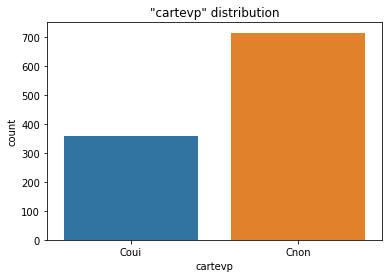

In [12]:
sns.countplot(x=visa.cartevp)
plt.title(f'"cartevp" distribution')

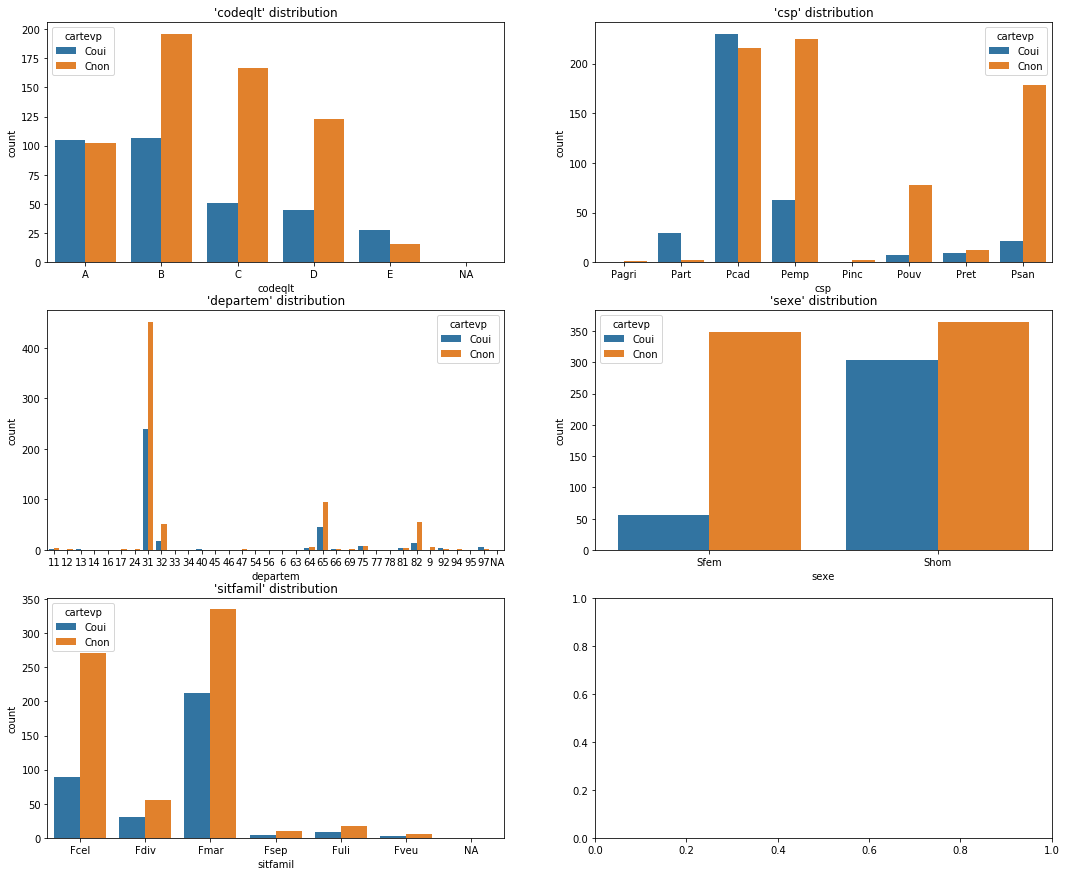

In [13]:
nrow, ncol = 3,2
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(visa_quali.shape[1]):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = quali_vars[i]
    
#     visa_quali[var_name].value_counts().sort_index().plot.bar(ax=ax)
    order=np.sort(visa_quali[var_name].fillna('NA').unique())
    sns.countplot(x=visa_quali[var_name], hue=visa.cartevp,
                  order=order, 
                  ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

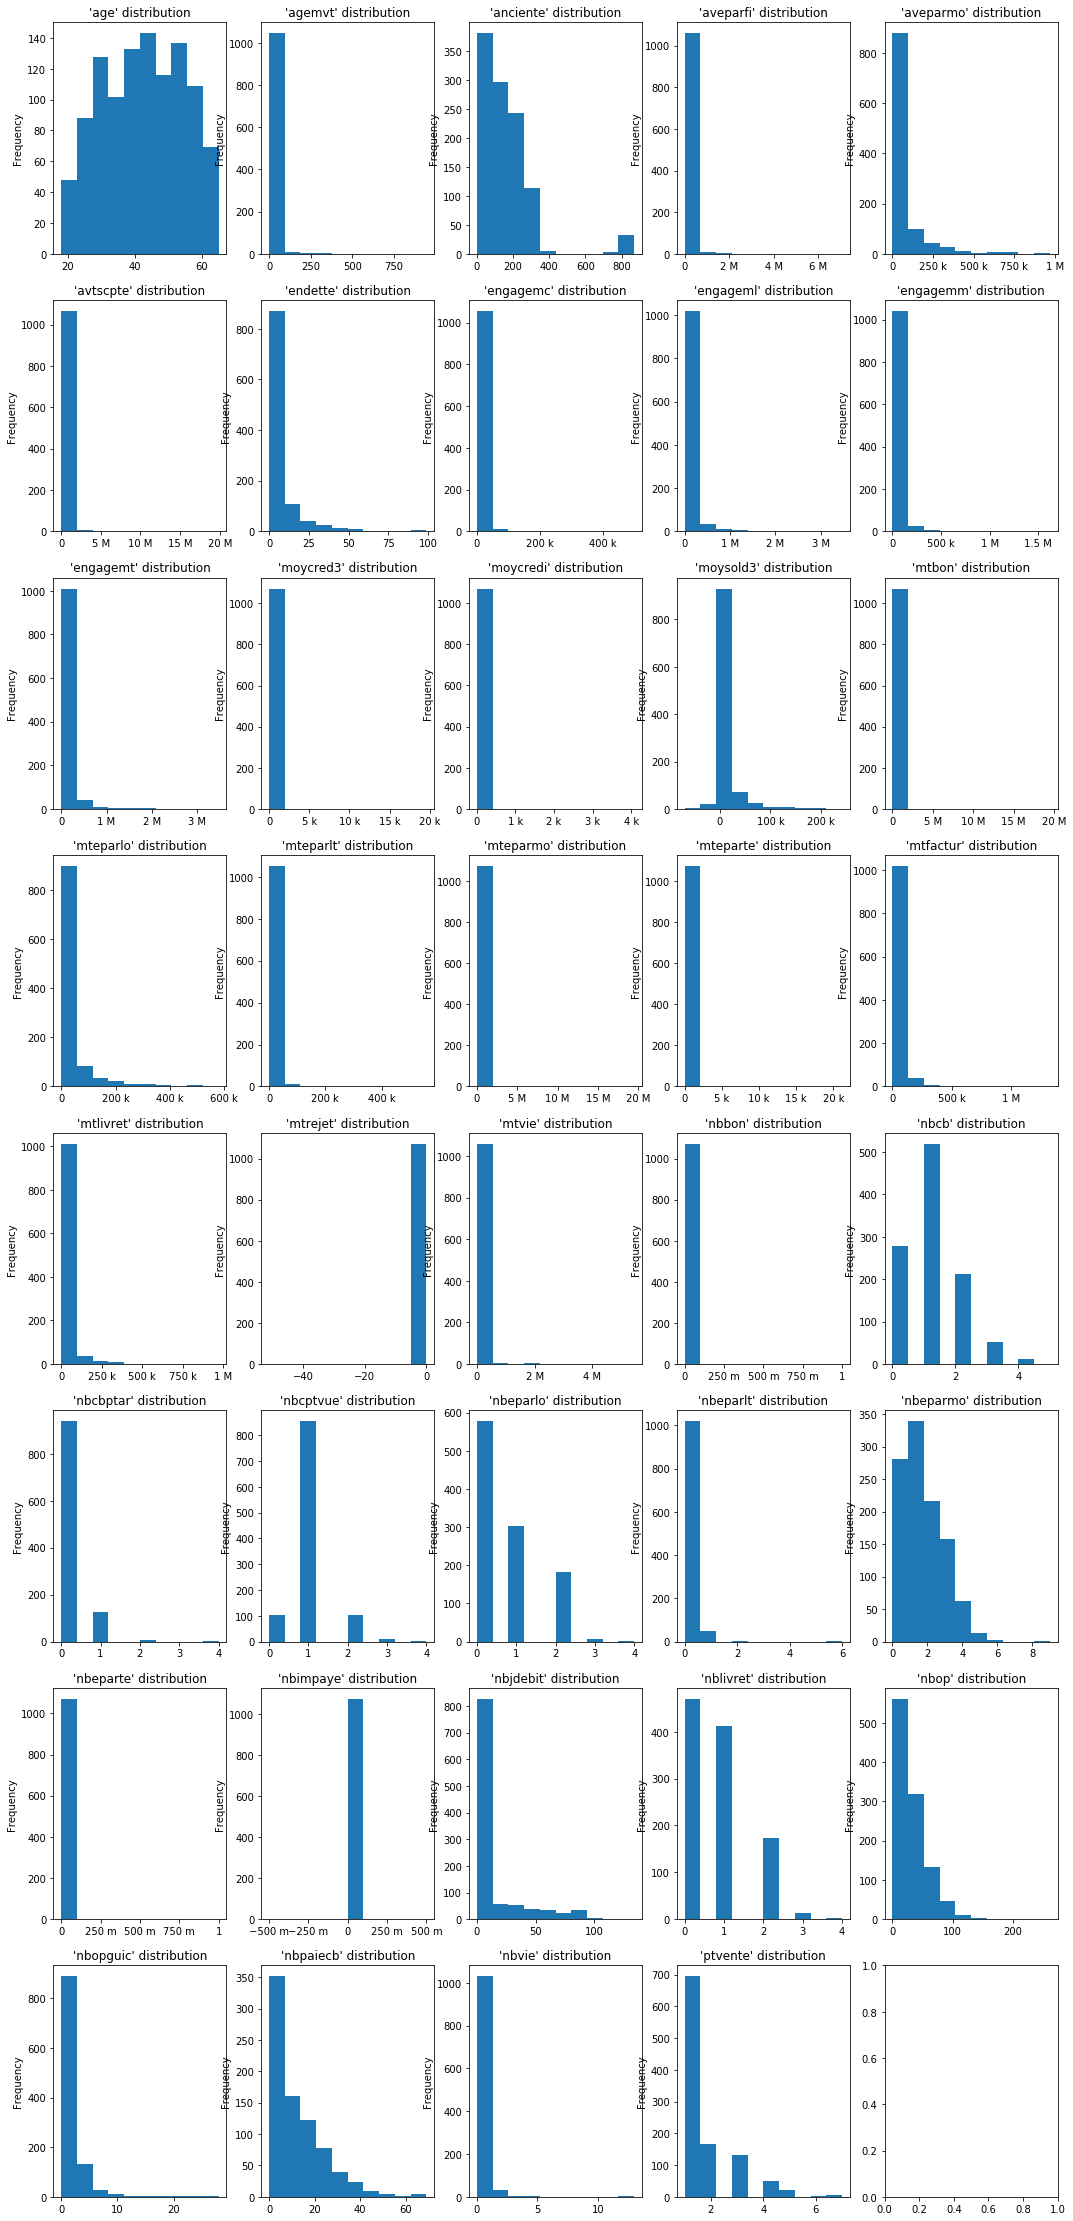

In [14]:
nvars = visa_quanti.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_quanti.columns[i]
    
    s = visa_quanti[var_name]
    s.plot.hist(ax=ax)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

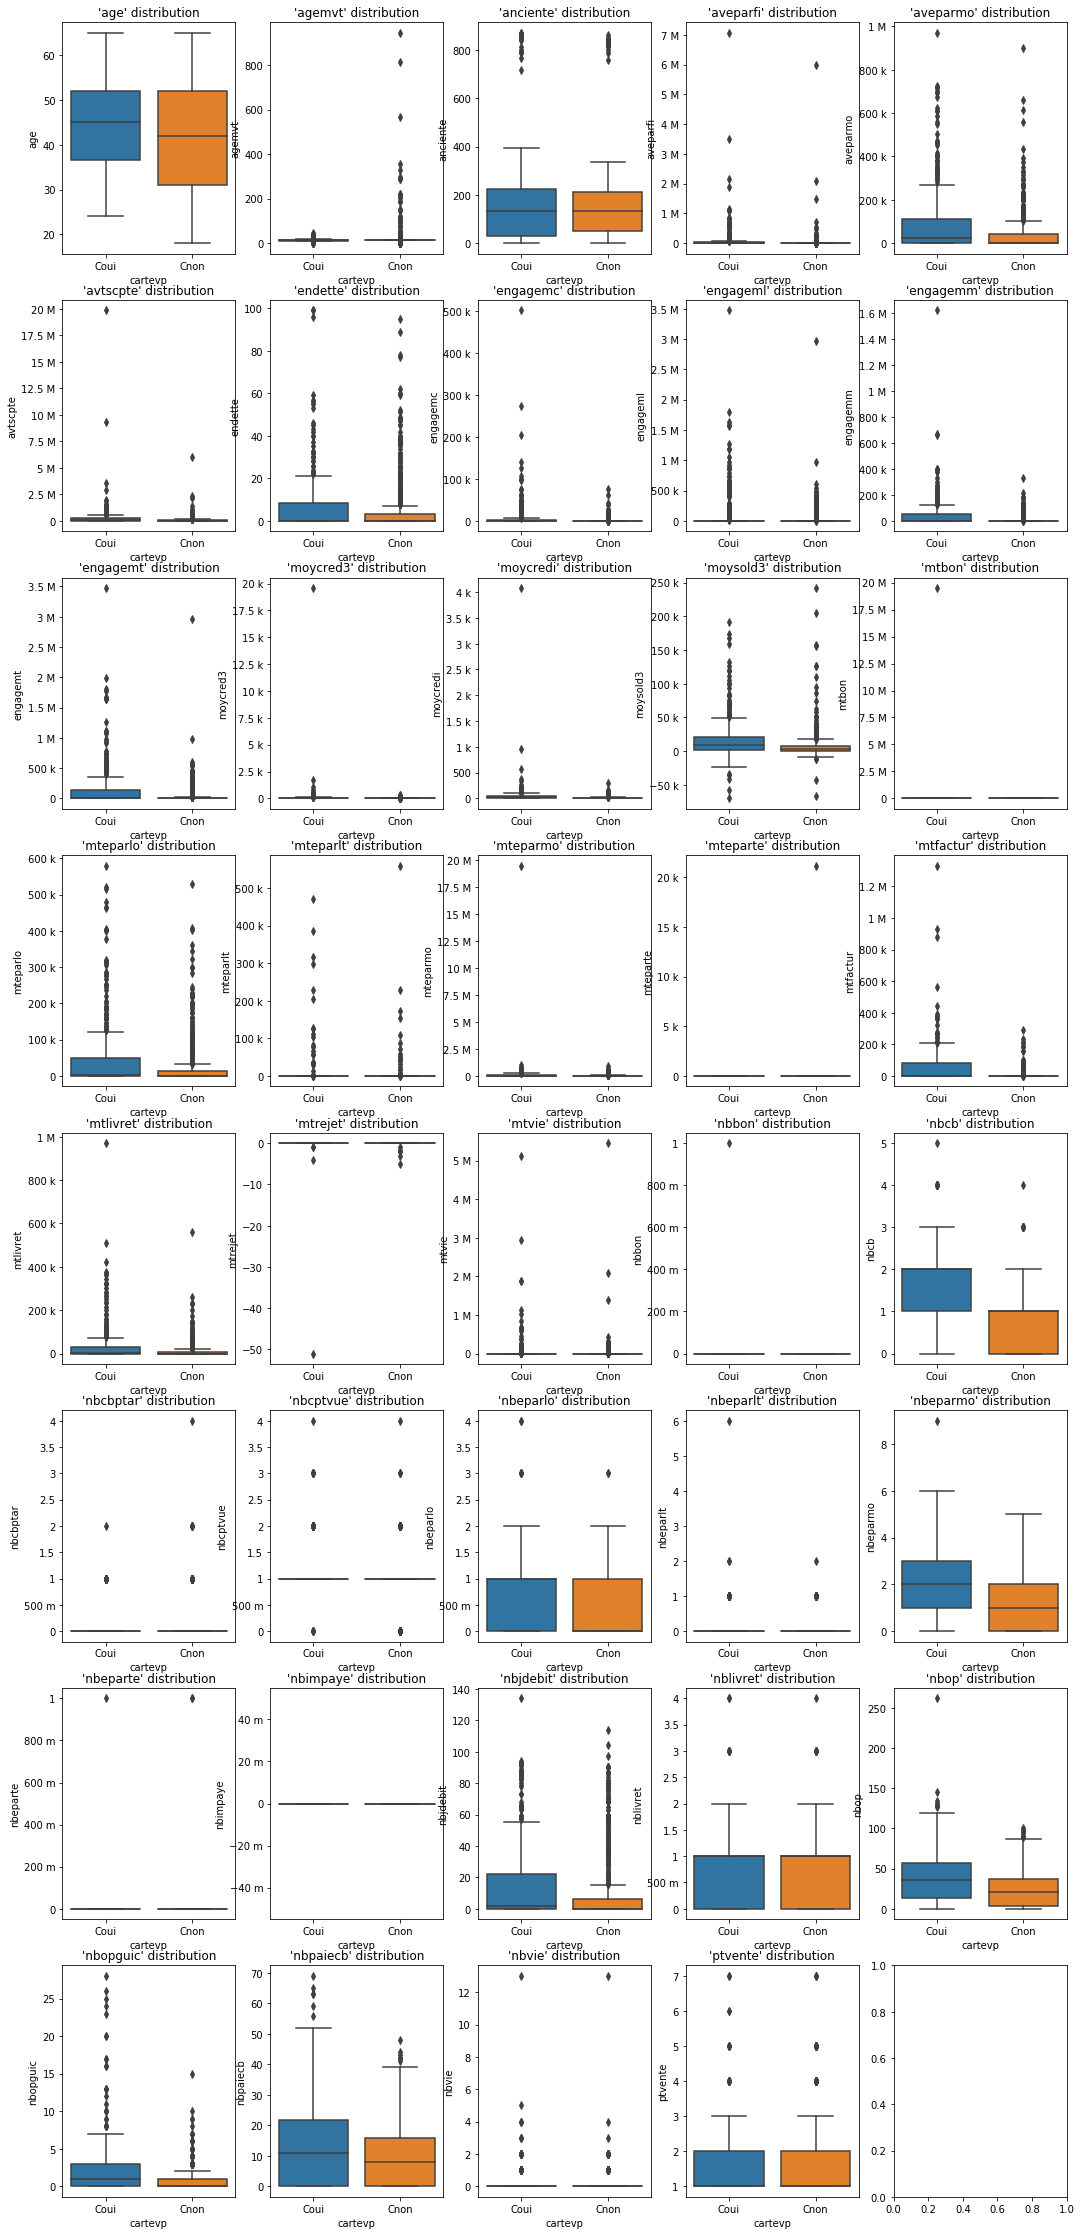

In [15]:
nvars = visa_quanti.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_quanti.columns[i]
    
    s = visa_quanti[var_name]
    sns.boxplot(x=visa.cartevp, y=s, ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [16]:
visa_log = visa_quanti.drop(columns=['nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt', 'nbeparte',
                                     'nblivret', 'nbvie', 'ptvente']).copy()
visa_log = visa_log.apply(lambda x: np.log(np.abs(x)+1))

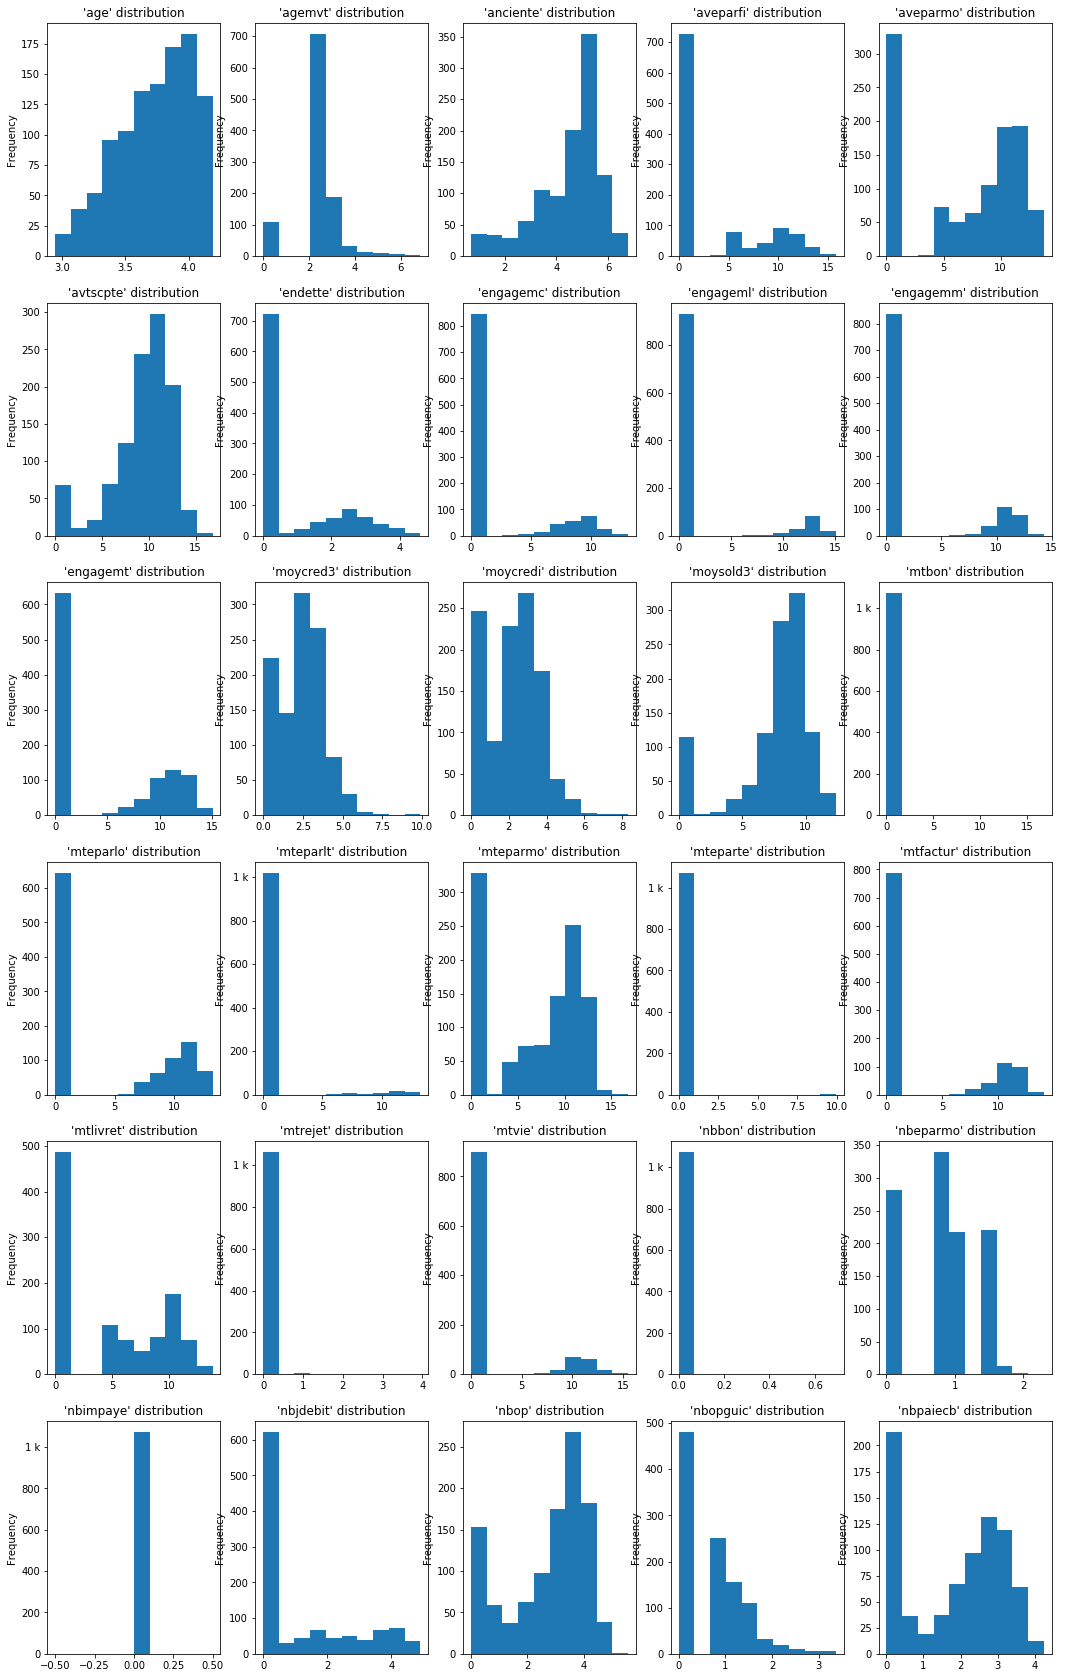

In [17]:
nvars = visa_log.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_log.columns[i]
    
    s = visa_log[var_name]
    s.plot.hist(ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [18]:
visa.nbimpaye.value_counts()

0.0    1073
Name: nbimpaye, dtype: int64

In [19]:
(visa[['engagemc', 'engagemm', 'engageml']].sum(axis=1).head() != visa.engagemt.head()).sum()

0

#### Suppression des variables inutiles
- `nbimpaye` parce que sa valeur est constante
- `engagemt` parce que sa valeur peut être calculée en fonction des variables `engagemc`, `engagemm` et `engageml`
- `departem` parce qu'elle a trop de modalités
- `nbpaiecb` parce qu'elle a trop de valeurs manquantes

In [20]:
visa = visa.drop(columns=['nbimpaye', 'engagemt', 'departem', 'nbpaiecb'])
visa_quanti = visa_quanti.drop(columns=['nbimpaye', 'engagemt', 'nbpaiecb'])
visa_quali = visa_quali.drop(columns=['departem'])

### Remplacement des valeurs manquantes:
Pour les variables numériques, nous utilisons la moyenne.
Pour les variables catégorielles, nous utilisons la modalité modale

In [21]:
new_vals = SimpleImputer().fit_transform(visa_quanti)
visa_quanti_new = pd.DataFrame(new_vals, columns=visa_quanti.columns)

new_vals = SimpleImputer(strategy='most_frequent').fit_transform(visa_quali)
visa_quali_new = pd.DataFrame(new_vals, columns=visa_quali.columns)

### Analyse multivariée

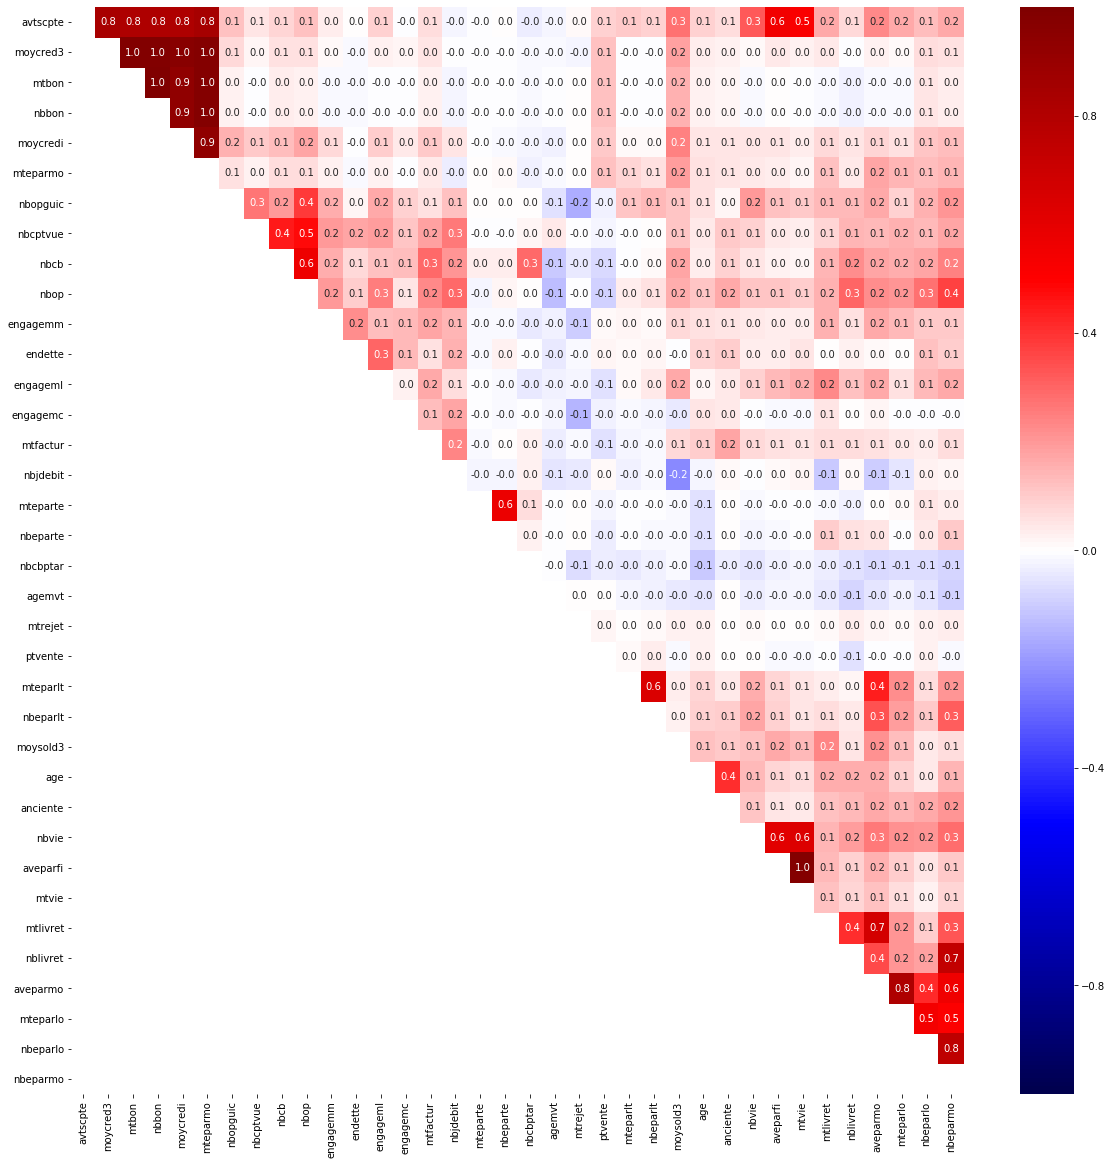

In [22]:
from scipy.cluster import hierarchy
def corplot(df):
    corr = df.corr() # calculate correlations
    d = 2 - 2*corr.values # convert to euclidean distances

    # creation of the dendrogram
    Z = hierarchy.linkage(d, method='ward')
    dn = hierarchy.dendrogram(Z,no_plot=True)
    idx = dn['leaves']
    
    # reorder rows and columns according to the order of the leaves
    cor = corr.copy()
    cor = cor.iloc[:, idx]
    cor = cor.iloc[idx, :]
    
    # delete the values under the diagonal
    idx = np.arange(cor.shape[0])
    mask = idx[:, np.newaxis] < idx
    cor.values[~mask] = np.nan
    

    ax = sns.heatmap(cor, annot=True, fmt='.1f', cmap='seismic', vmin=-1, vmax=1)
    # adjust ticks (problem on windows)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plt.figure(figsize=(20,20))
corplot(visa_quanti_new)

In [23]:
# # Pair plots
# sns.pairplot(visa_quanti.iloc[:,:4], hue=visa.cartevpr)
# axs = pd.plotting.scatter_matrix(visa_quanti.dropna(), #.iloc[:, :4],
#                            c=visa.cartevpr[~visa_quanti.isnull().any(axis=1)],
#                            figsize=(20, 20),
#                            marker='o', alpha=.8)
# for ax in axs.flat:
#     ax.xaxis.set_major_formatter(ticker.EngFormatter())
# #     ax.yaxis.set_major_formatter(ticker.EngFormatter())
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     for tick in ax.get_yticklabels():
#         tick.set_rotation(90)

#### Réduction de la dimension

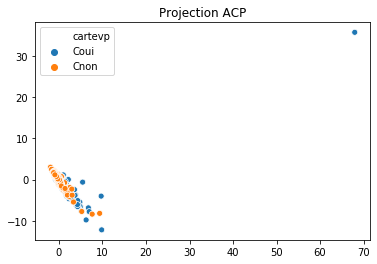

In [24]:
scaled = StandardScaler().fit_transform(visa_quanti_new)
pca_embed = PCA(n_components=2).fit_transform(scaled)
sns.scatterplot(pca_embed[:,0], pca_embed[:,1], hue=visa.cartevp)
plt.title('Projection ACP');

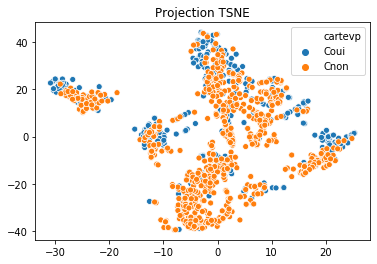

In [25]:
tsne_embed = TSNE(perplexity=50).fit_transform(visa_quanti_new)
sns.scatterplot(tsne_embed[:,0], tsne_embed[:,1], hue=visa.cartevp)
plt.title('Projection TSNE');

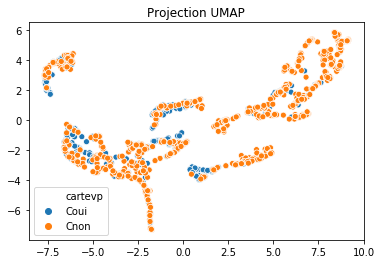

In [26]:
umap_embed = UMAP().fit_transform(visa_quanti_new)
sns.scatterplot(umap_embed[:,0], umap_embed[:,1], hue=visa.cartevp)
plt.title('Projection UMAP');

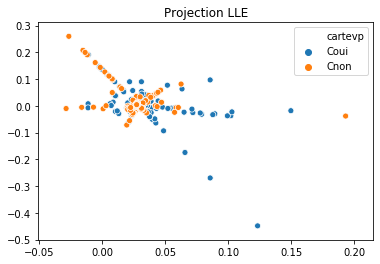

In [27]:
lle_embed = LocallyLinearEmbedding().fit_transform(visa_quanti_new)
sns.scatterplot(lle_embed[:,0], lle_embed[:,1], hue=visa.cartevp)
plt.title('Projection LLE');

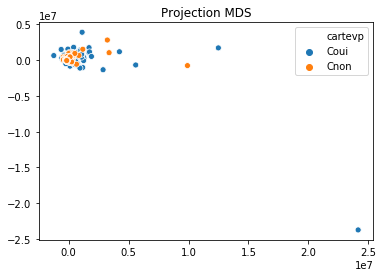

In [28]:
mds_embed = MDS().fit_transform(visa_quanti_new)
sns.scatterplot(mds_embed[:,0], mds_embed[:,1], hue=visa.cartevp)
plt.title('Projection MDS');

In [29]:
visa_new = pd.concat([visa_quanti_new, visa_quali_new, visa.cartevp], axis=1)

#### ACP avec R

R[write to console]: Loading required package: ggplot2

R[write to console]: Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



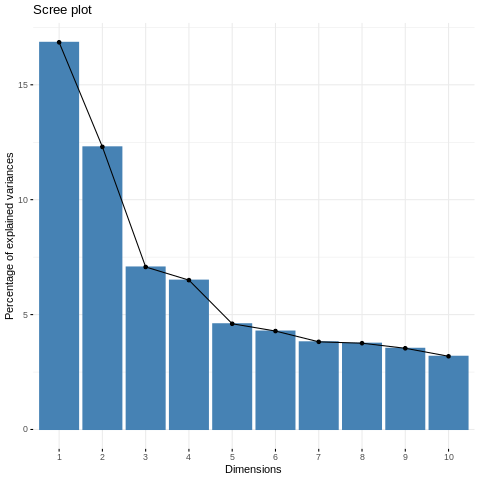

In [30]:
%%R -i visa_quanti_new -i visa_new -o acp
library(FactoMineR)
library(factoextra)
# library(corrplot)

df <- visa_quanti_new

acp <- PCA(df,ncp=ncol(df[-1,]), graph=FALSE) # , ind.sup=c(1,167)
fviz_screeplot(acp)
# fviz_contrib(acp, choice = "var", axes = 2, top = 10)
# fviz_pca_ind(acp, col.ind = "cos2", 
#              gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")
# #              ,
# #              repel = TRUE # Avoid text overlapping (slow if many points)
#              )

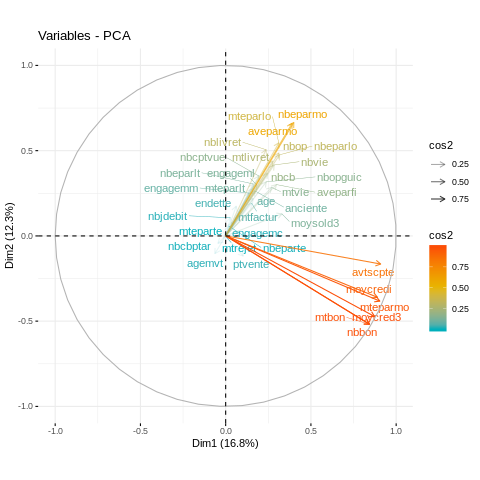

In [31]:
%%R -i acp
fviz_pca_var(acp,
             col.var = "cos2",
             alpha.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE
            )

#### AFDM

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



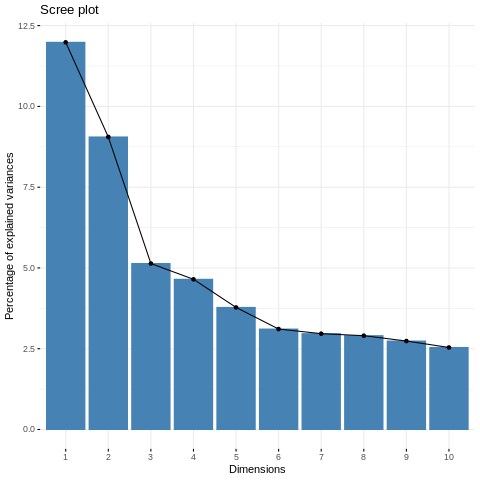

In [32]:
%%R -i visa_new -o afdm
df <- visa_new

library(FactoMineR)
library(tidyverse)
library(factoextra)

n <- nrow(df)
p <- ncol(df)

df[, (p-4):p] <- lapply(df[, (p-4):p], factor)
summary(df[, (p-4):p])

y_idx <- which(colnames(df) == 'cartevp')
afdm <- FAMD(df,ncp=ncol(df), graph=FALSE, sup.var=y_idx)

fviz_screeplot(afdm)

## Classification supervisée

### Préparation des données

###### Method 1: Données brutes

In [33]:
enc = OneHotEncoder(sparse=False)
quali_encode = enc.fit_transform(visa_quali_new)
df_visa_raw = pd.concat([visa_quanti_new, pd.DataFrame(quali_encode)], axis=1)

###### Method 2: ACP (Données quantitatives uniquement)

In [34]:
%%R -i acp -o visa_acp
visa_acp <- acp$ind$coord[,1:10]

In [35]:
df_visa_acp = pd.DataFrame(visa_acp)

###### Method 3: AFDM

In [36]:
%%R -i afdm -o visa_afdm
visa_afdm <- afdm$ind$coord[,1:15]

In [37]:
df_visa_afdm = pd.DataFrame(visa_afdm)

###### Method 4: ACP + variables catégorielles

In [38]:
df_visa_acp_cat = pd.concat([df_visa_acp, pd.DataFrame(quali_encode)], axis=1)

In [39]:
test_size = 0.20
seed = 7

y = visa.cartevpr.values

X_raw = df_visa_raw.values
X_acp = df_visa_acp.values
X_afdm = df_visa_afdm.values
X_acp_cat = df_visa_acp_cat.values

datasets = dict(
    raw = train_test_split(X_raw, y, test_size=test_size, random_state=seed), # use_all_models=False
    acp = train_test_split(X_acp, y, test_size=test_size, random_state=seed),
    afdm = train_test_split(X_afdm, y, test_size=test_size, random_state=seed),
    acp_cat = train_test_split(X_acp_cat, y, test_size=test_size, random_state=seed),
)

### Obtention du meilleur modèle pour chaque algorithme

In [40]:
# Test options and evaluation metric
num_folds = 10
scoring = 'roc_auc'
seed = 420

In [41]:
def train_model(model, X_train, y_train, name, param_grid, num_folds):
    print(f"Training model {name!r} with score {scoring!r} ...")
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

    grid.fit(X_train, y_train)

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    print()
    
    return grid

def get_cv_score(model, X_train, y_train, name, num_folds):
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    msg = f"{name}: {cv_results.mean():.4f} ({cv_results.std():.5f})"
    print(msg)
    return cv_results

In [42]:
def make_models():
    lr_params = dict(LR__C=[0.1, .5, .8, 1., 1.5, 2, 3])
    knn_params = dict(KNN__n_neighbors=range(7, 36, 2), KNN__leaf_size=range(5, 20))
    cart_params = dict(CART__min_samples_split=range(2, 15))
    c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
    lsvm_params = dict(SVM__C=c_values)
    kernel_values = ['poly', 'rbf', 'sigmoid']
    svm_params = dict(SVM__C=c_values, SVM__kernel=kernel_values)
    n_estimators = range(30, 111, 5)
    rf_params = dict(RF__n_estimators=n_estimators)
    ada_params = dict(AB__n_estimators=n_estimators)
    gb_params = dict(GB__n_estimators=n_estimators)
    et_params = dict(ET__n_estimators=n_estimators)
    
    return [
        ('NB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())]), None),
        ('LDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())]), None),
        ('QDA', Pipeline([('Scaler', StandardScaler()),('QDA', QuadraticDiscriminantAnalysis())]), None),
        ('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='lbfgs'))]), lr_params),
        ('KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())]), knn_params),
        ('CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())]), cart_params),
        ('LinearSVM', Pipeline([('Scaler', StandardScaler()),('SVM', LinearSVC())]), lsvm_params),
        ('KernelSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))]), svm_params),
        ('RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())]), rf_params),
        ('AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())]), ada_params),
        ('GB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier())]), gb_params),
        ('ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())]), et_params),
    ]


def train_models(models, X_train, y_train, data_name):
    print(f'Training the models using the data {data_name!r}')
    trained_models = [None] * len(models)
    for i, (name, clf, cv_params) in enumerate(models):
        if cv_params is None:
            trained_models[i] = (name, clf.fit(X_train, y_train))
        else:
            grid_result = train_model(clf, X_train, y_train, name, cv_params, num_folds)
            trained_models[i] = (name, grid_result.best_estimator_)
    print('Training complete')
    return trained_models

In [43]:
data_name = 'raw'
X_train, _, y_train, _ = datasets[data_name] 

models = make_models()
trained_raw = train_models(models, X_train, y_train, data_name)

Training the models using the data 'raw'
Training model 'LR' with score 'roc_auc' ...
Best: 0.916063 using {'LR__C': 0.5}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.872652 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 29}

Training model 'CART' with score 'roc_auc' ...
Best: 0.872875 using {'CART__min_samples_split': 14}

Training model 'LinearSVM' with score 'roc_auc' ...
Best: 0.915144 using {'SVM__C': 0.1}

Training model 'KernelSVM' with score 'roc_auc' ...
Best: 0.924824 using {'SVM__C': 2.0, 'SVM__kernel': 'rbf'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.949474 using {'RF__n_estimators': 45}

Training model 'AB' with score 'roc_auc' ...
Best: 0.956965 using {'AB__n_estimators': 45}

Training model 'GB' with score 'roc_auc' ...
Best: 0.964947 using {'GB__n_estimators': 105}

Training model 'ET' with score 'roc_auc' ...
Best: 0.933005 using {'ET__n_estimators': 75}

Training complete


In [44]:
data_name = 'acp'
X_train, _, y_train, _ = datasets[data_name] 

models = make_models()
trained_acp = train_models(models, X_train, y_train, data_name)

Training the models using the data 'acp'
Training model 'LR' with score 'roc_auc' ...
Best: 0.812194 using {'LR__C': 3}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.808631 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 25}

Training model 'CART' with score 'roc_auc' ...
Best: 0.723026 using {'CART__min_samples_split': 14}

Training model 'LinearSVM' with score 'roc_auc' ...
Best: 0.814409 using {'SVM__C': 2.0}

Training model 'KernelSVM' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.817030 using {'SVM__C': 2.0, 'SVM__kernel': 'rbf'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.829025 using {'RF__n_estimators': 90}

Training model 'AB' with score 'roc_auc' ...
Best: 0.794030 using {'AB__n_estimators': 30}

Training model 'GB' with score 'roc_auc' ...
Best: 0.830161 using {'GB__n_estimators': 70}

Training model 'ET' with score 'roc_auc' ...
Best: 0.827920 using {'ET__n_estimators': 95}

Training complete


In [45]:
data_name = 'afdm'
X_train, _, y_train, _ = datasets[data_name] 

models = make_models()
trained_afdm = train_models(models, X_train, y_train, data_name)

Training the models using the data 'afdm'
Training model 'LR' with score 'roc_auc' ...
Best: 0.866892 using {'LR__C': 3}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.843704 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 31}

Training model 'CART' with score 'roc_auc' ...
Best: 0.753862 using {'CART__min_samples_split': 13}

Training model 'LinearSVM' with score 'roc_auc' ...
Best: 0.867142 using {'SVM__C': 1.3}

Training model 'KernelSVM' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.864370 using {'SVM__C': 1.3, 'SVM__kernel': 'rbf'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.863367 using {'RF__n_estimators': 100}

Training model 'AB' with score 'roc_auc' ...
Best: 0.824374 using {'AB__n_estimators': 30}

Training model 'GB' with score 'roc_auc' ...
Best: 0.853208 using {'GB__n_estimators': 30}

Training model 'ET' with score 'roc_auc' ...
Best: 0.868458 using {'ET__n_estimators': 60}

Training complete


In [46]:
data_name = 'acp_cat'
X_train, _, y_train, _ = datasets[data_name] 

models = make_models()
trained_acp_cat = train_models(models, X_train, y_train, data_name)

Training the models using the data 'acp_cat'
Training model 'LR' with score 'roc_auc' ...
Best: 0.866926 using {'LR__C': 1.0}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.833658 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 35}

Training model 'CART' with score 'roc_auc' ...
Best: 0.751360 using {'CART__min_samples_split': 14}

Training model 'LinearSVM' with score 'roc_auc' ...
Best: 0.867354 using {'SVM__C': 2.0}

Training model 'KernelSVM' with score 'roc_auc' ...
Best: 0.866250 using {'SVM__C': 0.9, 'SVM__kernel': 'rbf'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.879594 using {'RF__n_estimators': 65}

Training model 'AB' with score 'roc_auc' ...
Best: 0.859003 using {'AB__n_estimators': 35}

Training model 'GB' with score 'roc_auc' ...
Best: 0.877849 using {'GB__n_estimators': 35}

Training model 'ET' with score 'roc_auc' ...
Best: 0.867574 using {'ET__n_estimators': 50}

Training complete


#### Comparaison des modèles

In [47]:
model_names = [name for (name, _) in trained_raw]
print()
scores_raw = [get_cv_score(model, datasets['raw'][0], y_train, name, num_folds) for (name, model) in trained_raw]
print()
scores_acp = [get_cv_score(model, datasets['acp'][0], y_train, name, num_folds) for (name, model) in trained_acp]
print()
scores_afdm = [get_cv_score(model, datasets['afdm'][0], y_train, name, num_folds) for (name, model) in trained_afdm]
print()
scores_acp_cat = [get_cv_score(model, datasets['acp_cat'][0], y_train, name, num_folds) for (name, model) in trained_acp_cat]


NB: 0.8516 (0.04351)
LDA: 0.9084 (0.02678)
QDA: 0.7510 (0.08094)
LR: 0.9160 (0.02473)
KNN: 0.8727 (0.03381)
CART: 0.8694 (0.03738)
LinearSVM: 0.9151 (0.02610)
KernelSVM: 0.9248 (0.02242)
RF: 0.9385 (0.02476)
AB: 0.9569 (0.01815)
GB: 0.9646 (0.01778)
ET: 0.9246 (0.02706)

NB: 0.7282 (0.06029)
LDA: 0.7998 (0.06634)
QDA: 0.7663 (0.05440)
LR: 0.8122 (0.05942)
KNN: 0.8087 (0.03684)
CART: 0.7341 (0.02924)
LinearSVM: 0.8149 (0.06179)
KernelSVM: 0.8171 (0.05282)
RF: 0.8269 (0.03651)
AB: 0.7939 (0.06365)
GB: 0.8297 (0.03667)
ET: 0.8215 (0.04156)

NB: 0.7832 (0.04629)
LDA: 0.8549 (0.03645)
QDA: 0.8346 (0.04172)
LR: 0.8669 (0.03399)
KNN: 0.8438 (0.03580)
CART: 0.7375 (0.04455)
LinearSVM: 0.8670 (0.03310)
KernelSVM: 0.8644 (0.03453)
RF: 0.8564 (0.03566)
AB: 0.8244 (0.03964)
GB: 0.8530 (0.03604)
ET: 0.8570 (0.02768)

NB: 0.8140 (0.02712)
LDA: 0.8618 (0.03313)
QDA: 0.7234 (0.08331)
LR: 0.8670 (0.03351)
KNN: 0.8337 (0.03255)
CART: 0.7503 (0.05195)
LinearSVM: 0.8659 (0.03123)
KernelSVM: 0.8663 (0.030

In [48]:
n_models = len(model_names)
data_names = [*datasets.keys()]
n_datasets = len(data_names)

In [49]:
avg_scores = np.apply_along_axis(np.mean, 1, scores_raw+scores_acp+scores_afdm+scores_acp_cat)
avg_scores = np.round(avg_scores, 3)
df_scores = pd.DataFrame({
    'Données': np.array([[name]*n_models for name in data_names]).reshape((-1,)),
    'Algo': model_names*n_datasets,
    scoring: avg_scores,
}).pivot('Données', 'Algo')

In [50]:
df_scores.to_csv(f'../output/models_{scoring}_scores.csv')

In [51]:
cm = sns.light_palette("green", as_cmap=True)
df_scores.style.background_gradient(cmap=cm)

### Best model

In [52]:
name, best_model = trained_raw[-2]
best_data = 'raw'
_, X_test, _, y_test = datasets[best_data]
y_pred = best_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       141
           1       0.95      0.85      0.90        74

    accuracy                           0.93       215
   macro avg       0.94      0.92      0.93       215
weighted avg       0.94      0.93      0.93       215

